  Preparing metadata (setup.py) ... done
🔼 Upload your naflt.zip file


Saving naflt.zip to naflt.zip
✅ Dataset loaded with shape: (318551, 12)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:18:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:18:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🩸 Mortality Model Evaluation:
📋 Classification Report:
              precision    recall  f1-score   support

       Alive       0.98      1.00      0.99    284663
    Deceased       0.99      0.87      0.93     33888

    accuracy                           0.99    318551
   macro avg       0.99      0.93      0.96    318551
weighted avg       0.99      0.99      0.98    318551



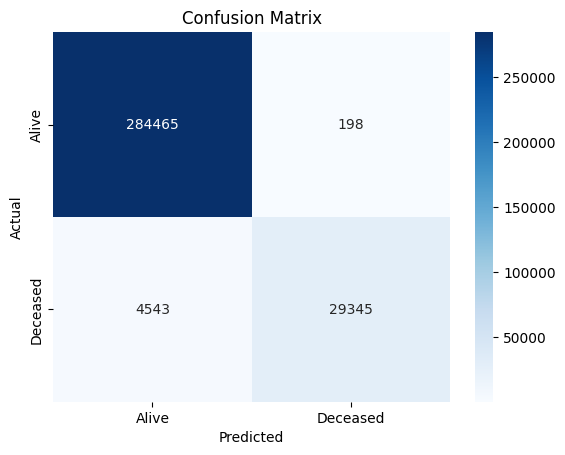


📊 Disease Stage Model Evaluation:
📋 Classification Report:
              precision    recall  f1-score   support

       Early       1.00      1.00      1.00     53955
Intermediate       1.00      1.00      1.00     90966
    Advanced       1.00      1.00      1.00    173630

    accuracy                           1.00    318551
   macro avg       1.00      1.00      1.00    318551
weighted avg       1.00      1.00      1.00    318551



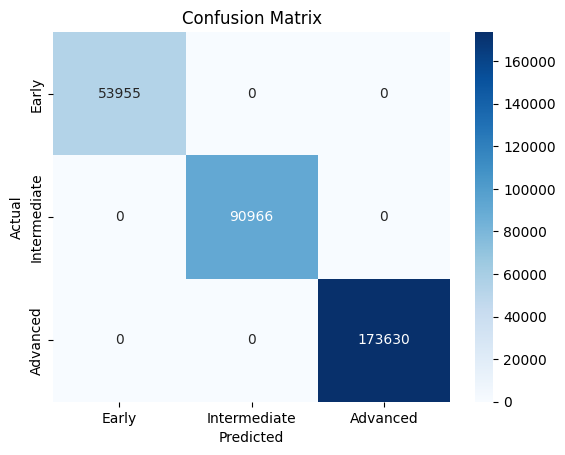


📤 Upload a test CSV file for prediction:


Saving test.csv to test.csv

✅ Predictions:
    case.id Predicted Mortality Predicted Stage
0  0.833262               Alive        Advanced
1 -1.558007               Alive           Early
2  0.801476               Alive    Intermediate
3  1.715112               Alive        Advanced
4 -1.036922               Alive        Advanced


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 📦 STEP 1: INSTALL REQUIRED LIBRARIES
!pip install -q xgboost scikit-learn pandas matplotlib seaborn fpdf

# 📚 STEP 2: IMPORT LIBRARIES
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from google.colab import files
from fpdf import FPDF

# 📂 STEP 3: UPLOAD AND UNZIP THE DATASET
print("🔼 Upload your naflt.zip file")
uploaded = files.upload()

for filename in uploaded:
    if filename.endswith('.zip'):
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("/content/naflt_data")

# 📁 STEP 4: LOAD TRAIN AND TEST CSV FILES
train_path = "/content/naflt_data/train.csv"
test_path = "/content/naflt_data/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
print("✅ Dataset loaded with shape:", train_df.shape)

# 🛠️ STEP 5: FIX STATUS COLUMN
train_df['status'] = (train_df['status'] > 0).astype(int)
test_df['status'] = (test_df['status'] > 0).astype(int)

# 🧠 STEP 6: SYNTHETIC DISEASE STAGE FROM FUTIME
def create_stage_column(df):
    bins = [-np.inf, 0, 1, np.inf]
    labels = [2, 1, 0]  # 2 = Advanced, 1 = Intermediate, 0 = Early
    df['stage'] = pd.cut(df['futime'], bins=bins, labels=labels).astype(int)
    return df

train_df = create_stage_column(train_df)
test_df = create_stage_column(test_df)

# 🧹 STEP 7: DATA PREPARATION
def prepare_data(df, target_col):
    X = df.drop(columns=[target_col, 'case.id'])
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

X_mortality, y_mortality, scaler_bin = prepare_data(train_df.copy(), 'status')
X_stage, y_stage, scaler_multi = prepare_data(train_df.copy(), 'stage')

# 🧠 STEP 8: TRAIN XGBOOST MODELS
model_bin = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False)
model_multi = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric="mlogloss", use_label_encoder=False)

model_bin.fit(X_mortality, y_mortality)
model_multi.fit(X_stage, y_stage)

# 📊 STEP 9: EVALUATION FUNCTION
def evaluate_model(model, X, y, labels):
    y_pred = model.predict(X)
    print("📋 Classification Report:")
    print(classification_report(y, y_pred, target_names=labels))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# 🧪 STEP 10: EVALUATE BOTH MODELS
print("\n🩸 Mortality Model Evaluation:")
evaluate_model(model_bin, X_mortality, y_mortality, labels=["Alive", "Deceased"])

print("\n📊 Disease Stage Model Evaluation:")
evaluate_model(model_multi, X_stage, y_stage, labels=["Early", "Intermediate", "Advanced"])

# 📝 STEP 11: USER TEST CSV UPLOAD & PREDICTION + PDF REPORT
print("\n📤 Upload a test CSV file for prediction:")
uploaded = files.upload()

for filename in uploaded:
    test_user_df = pd.read_csv(filename)

    test_user_df['status'] = (test_user_df['status'] > 0).astype(int)
    test_user_df = create_stage_column(test_user_df)

    X_user_bin = scaler_bin.transform(test_user_df.drop(columns=['status', 'case.id']))
    X_user_stage = scaler_multi.transform(test_user_df.drop(columns=['stage', 'case.id']))

    pred_mortality = model_bin.predict(X_user_bin)
    pred_stage = model_multi.predict(X_user_stage)

    mortality_label = ["Alive" if i == 0 else "Deceased" for i in pred_mortality]
    stage_map = {0: "Early", 1: "Intermediate", 2: "Advanced"}
    stage_label = [stage_map[i] for i in pred_stage]

    result_df = test_user_df[['case.id']].copy()
    result_df['Predicted Mortality'] = mortality_label
    result_df['Predicted Stage'] = stage_label

    print("\n✅ Predictions:")
    print(result_df.head())

    result_df.to_csv("predictions.csv", index=False)
    files.download("predictions.csv")

    # 📄 GENERATE PDF REPORT
    class PDFReport(FPDF):
        def header(self):
            self.set_font("Arial", "B", 14)
            self.cell(0, 10, "NAFLD-HCC Prediction Report", ln=True, align="C")
            self.ln(10)

        def footer(self):
            self.set_y(-15)
            self.set_font("Arial", "I", 10)
            self.cell(0, 10, f"Page {self.page_no()}", align="C")

        def add_summary(self, result_df):
            self.set_font("Arial", "", 12)
            self.cell(0, 10, f"Total Records: {len(result_df)}", ln=True)
            self.cell(0, 10, f"Alive: {(result_df['Predicted Mortality'] == 'Alive').sum()}", ln=True)
            self.cell(0, 10, f"Deceased: {(result_df['Predicted Mortality'] == 'Deceased').sum()}", ln=True)
            self.ln(5)
            self.cell(0, 10, "Predicted Stages Count:", ln=True)
            for stage in result_df['Predicted Stage'].unique():
                count = (result_df['Predicted Stage'] == stage).sum()
                self.cell(0, 10, f" - {stage}: {count}", ln=True)
            self.ln(10)

        def add_preview_table(self, result_df):
            self.set_font("Arial", "B", 12)
            self.cell(0, 10, "Sample Predictions (Top 5)", ln=True)
            self.set_font("Arial", "", 11)
            for i in result_df.head(5).itertuples():
                self.cell(0, 10, f"Case ID: {i[1]}, Mortality: {i[2]}, Stage: {i[3]}", ln=True)

    pdf = PDFReport()
    pdf.add_page()
    pdf.add_summary(result_df)
    pdf.add_preview_table(result_df)
    pdf.output("prediction_summary.pdf")
    files.download("prediction_summary.pdf")